In [55]:
import torch

from Transformer import Transformer, ModelArgs

import pickle

import numpy as np
import matplotlib.pyplot as plt
import pacmap
from umap import UMAP

/opt/anaconda3/envs/brainhack/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [132]:
# Initialize model for inference

config = {
        'data_dir': 'output',
        'log_dir': 'logs',
        'checkpoint_dir': 'checkpoints',
        'sequence_length': 16,
        'batch_size': 32,
        'learning_rate': 1e-4,
        'num_epochs': 50,
        'device': 'mps',
        'model_dim': 512,  # Match the embedding dimension
        'n_layers': 8,
        'n_heads': 8,
        'train_ratio': 0.7,
        'val_ratio': 0.15
    }

model_args = ModelArgs(
        dim=config['model_dim'],
        n_layers=config['n_layers'],
        n_heads=config['n_heads'],
        max_batch_size=config['batch_size'],
        max_seq_len=config['sequence_length'],
        device=config['device']
    )

model = Transformer(model_args).to(config['device'])
model.eval()

#load checkpoint
checkpoint = torch.load('checkpoints/best_model.pt', map_location=torch.device('mps')) # if GPU unavailable
# checkpoint = torch.load('checkpoints/best_model.pt') # if GPU available

model.load_state_dict(checkpoint['model_state_dict'])

/var/folders/x6/d9qjznp95k7dlyz6y09vpct80000gn/T/ipykernel_53475/2784070149.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/best_mo

<All keys matched successfully>

In [133]:
patient = 34
data = pickle.load(open(f'output/jackal/Epat{patient}/embeddings_Epat{patient}_60win30str_train.pkl', "rb"))

# Get embeddings and reshape
embeddings = data['patient_embeddings']
print(f"Original embeddings shape for patient Epat{patient}: {embeddings.shape}")

# Reshape to (n_files*n_timepoints, n_features)
n_files, n_timepoints, n_features = embeddings.shape
embeddings_flat = embeddings.reshape(-1, n_features)
print(f"Reshaped embeddings: {embeddings_flat.shape}")


Original embeddings shape for patient Epat34: (680, 32, 512)
Reshaped embeddings: (21760, 512)


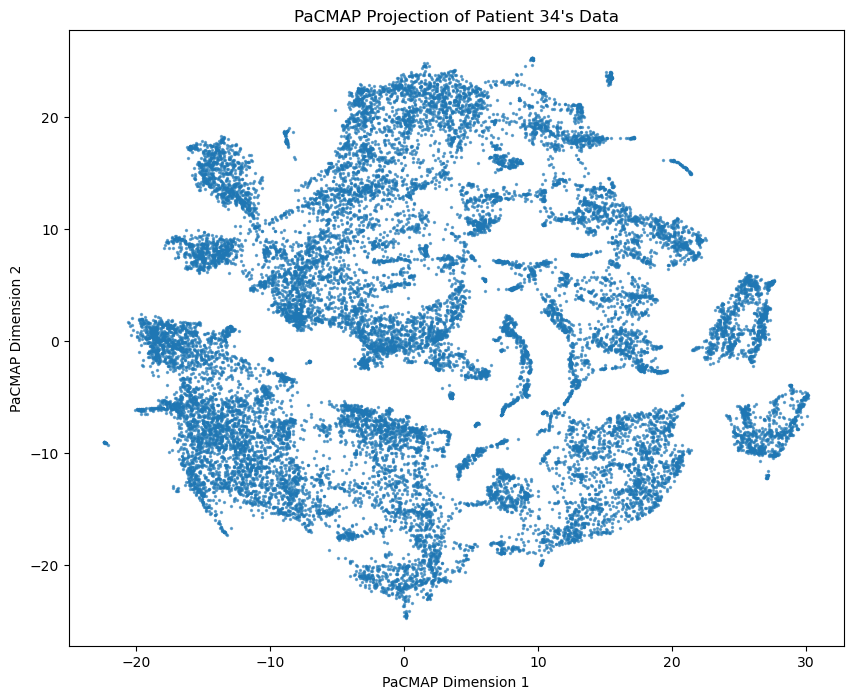

In [126]:
# Project patient embeddings to 2D manifold with PACMAP
project_to_manifold = pacmap.PaCMAP(n_components=2, MN_ratio=20.0, FP_ratio=15.0, 
                                distance='angular')
manifold = project_to_manifold.fit_transform(embeddings_flat)

# Plot PACMAP projection
plt.figure(figsize=(10, 8))
plt.scatter(manifold[:, 0], manifold[:, 1], s=2, alpha=0.6)
plt.title(f"PaCMAP Projection of Patient {patient}'s Data")
plt.xlabel("PaCMAP Dimension 1")
plt.ylabel("PaCMAP Dimension 2")
plt.show()

Selected states from file 89, starting at offset 0
True states shape: (32, 512)


/var/folders/x6/d9qjznp95k7dlyz6y09vpct80000gn/T/ipykernel_53475/682118227.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=colors[-1], s=50, label='Start')  # End color
/var/folders/x6/d9qjznp95k7dlyz6y09vpct80000gn/T/ipykernel_53475/682118227.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=colors[0], s=50, label='End')     # Start color


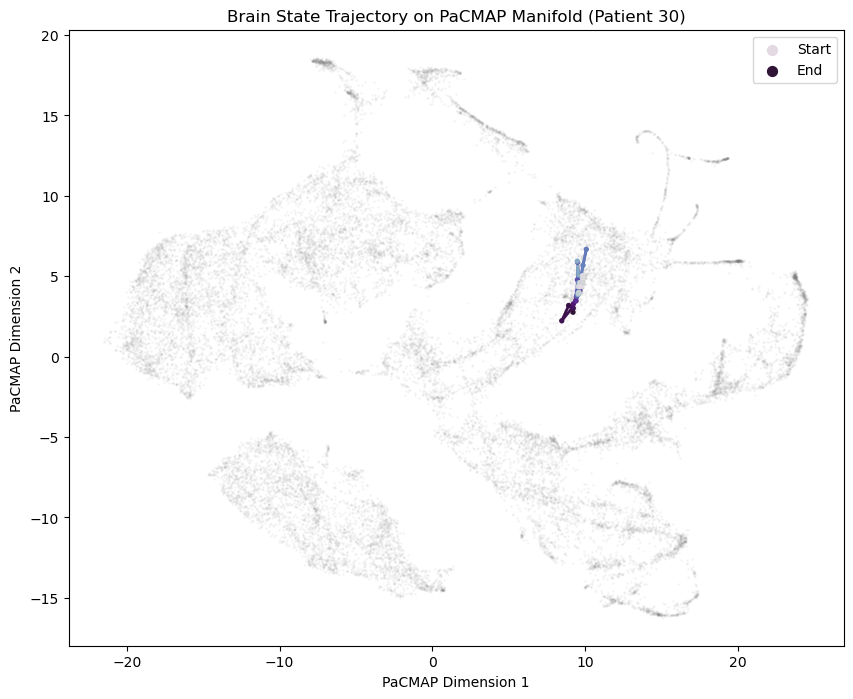

In [39]:
# Pick stretch of 32 brain states for 'ground truth' states
# Get random file index
file_idx = np.random.randint(0, n_files)

# Get indices for all embeddings from that file
file_start_idx = file_idx * n_timepoints 
file_end_idx = (file_idx + 1) * n_timepoints

# Pick random starting point within the file, ensuring room for 32 states
if n_timepoints <= 32:
    start_offset = 0
else:
    start_offset = np.random.randint(0, n_timepoints - 32)
start_idx = file_start_idx + start_offset

# Extract 32 continuous states
true_states = embeddings_flat[start_idx:start_idx + 32]

print(f"Selected states from file {file_idx}, starting at offset {start_offset}")
print(f"True states shape: {true_states.shape}")

# Get pacmap coordinates for the 32 states
true_states_2d = project_to_manifold.transform(true_states, basis=embeddings_flat)

# Create color gradient using seaborn twilight colormap
# Use only half the colormap to avoid wrapping back to start color
colors = plt.cm.twilight(np.linspace(0.5, 0, len(true_states_2d)))  # Reversed the gradient

# Create figure and plot
plt.figure(figsize=(10, 8))

# Plot original manifold points in gray
plt.scatter(manifold[:, 0], manifold[:, 1], s=1, alpha=0.05, c='gray')

# Plot the trajectory with gradient colors and lines connecting points
for i in range(len(true_states_2d)-1):
    plt.plot(true_states_2d[i:i+2, 0], true_states_2d[i:i+2, 1], 
             c=colors[i], linewidth=2)
    
# Plot points over lines to make them more visible
plt.scatter(true_states_2d[:, 0], true_states_2d[:, 1], 
           c=colors, s=8, zorder=2)

# Add start and end points to legend using scatter plots with empty labels
plt.scatter([], [], c=colors[-1], s=50, label='Start')  # End color
plt.scatter([], [], c=colors[0], s=50, label='End')     # Start color

plt.title(f"Brain State Trajectory on PaCMAP Manifold (Patient {patient})")
plt.xlabel("PaCMAP Dimension 1")
plt.ylabel("PaCMAP Dimension 2")
plt.legend(loc='upper right')
plt.show()

In [42]:
# Initialize context window with 32 states before the true states
context_start_idx = start_idx - 32  # Get 32 states before our true sequence
context = embeddings_flat[context_start_idx:start_idx].copy().astype(np.float32)  # Shape: (32, 512)

# Initialize array to store predictions
predicted_states = np.zeros_like(true_states, dtype=np.float32)  # Shape: (32, 512)

# Generate predictions one at a time
for i in range(len(true_states)):
    # Convert context to tensor and add batch dimension
    context_tensor = torch.tensor(context, device='mps', dtype=torch.float32).unsqueeze(0)  # Shape: (1, 32, 512)
    
    # Get model prediction (use no_grad since we're just inferring)
    with torch.no_grad():
        prediction = model(context_tensor)  # Shape: (1, 32, 512)
        
    # Extract the last state prediction and convert to numpy
    predicted_state = prediction[0, -1].detach().cpu().numpy().astype(np.float32)  # Shape: (512,)
    
    # Store the prediction
    predicted_states[i] = predicted_state
    
    # Update context window: remove earliest state and add predicted state
    context = np.roll(context, -1, axis=0)  # Shift everything left by 1
    context[-1] = predicted_state  # Add prediction at the end

print(f"Generated predictions shape: {predicted_states.shape}")


Generated predictions shape: (32, 512)


/var/folders/x6/d9qjznp95k7dlyz6y09vpct80000gn/T/ipykernel_53475/446848022.py:72: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=true_colors[-1], s=50, label='True Start')
/var/folders/x6/d9qjznp95k7dlyz6y09vpct80000gn/T/ipykernel_53475/446848022.py:73: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=true_colors[0], s=50, label='True End')
/var/folders/x6/d9qjznp95k7dlyz6y09vpct80000g

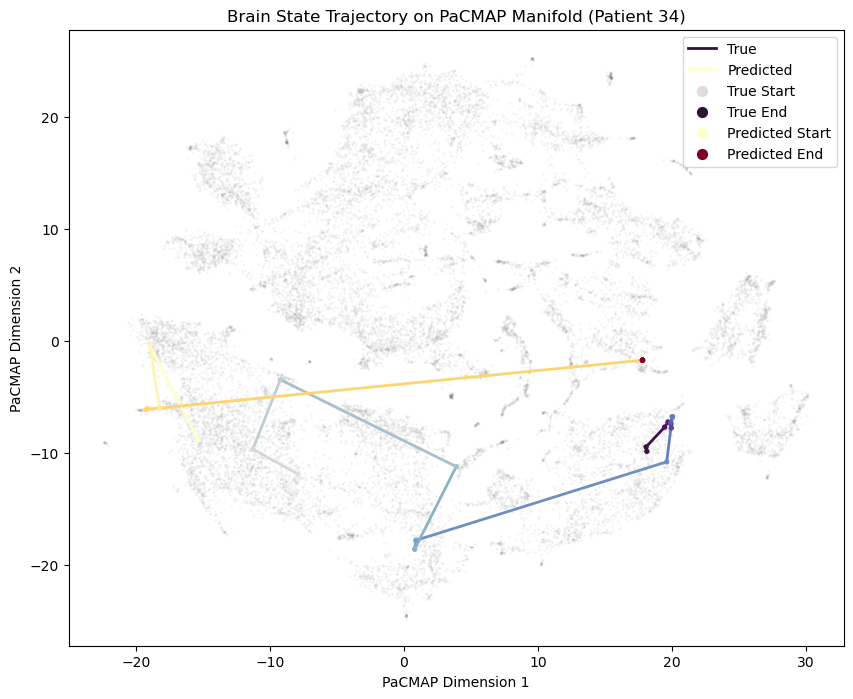

In [140]:
# AUTOREGRESSIVE PREDICTION WITH PACMAP
# GENERATE TRUE TRAJECTORY
# Get random file index
file_idx = np.random.randint(0, n_files)

# Get starting index for this file's states
start_idx = file_idx * 32

# Extract all 32 states
all_states = embeddings_flat[start_idx:start_idx + 32]

# True states are the last 16 states (indices 16-31)
true_states = all_states[16:]

# Initialize context with first 16 states
context = all_states[:16].copy().astype(np.float32)  # Shape: (16, 512)

# Initialize array to store predictions for states 17-32
predicted_states = np.zeros((16, 512), dtype=np.float32)  # Shape: (16, 512)

# Generate predictions one at a time
for i in range(16):  # Generate 16 predictions (for states 17-32)
    # Convert context to tensor and add batch dimension
    context_tensor = torch.tensor(context, device='mps', dtype=torch.float32).unsqueeze(0)  # Shape: (1, 16, 512)
    
    # Get model prediction (use no_grad since we're just inferring)
    with torch.no_grad():
        prediction = model(context_tensor)  # Shape: (1, 16, 512)
        
    # Extract the last state prediction and convert to numpy
    predicted_state = prediction[0, -1].detach().cpu().numpy().astype(np.float32)  # Shape: (512,)
    
    # Store the prediction
    predicted_states[i] = predicted_state
    
    # Update context window: remove earliest state and add predicted state
    context = np.roll(context, -1, axis=0)  # Shift everything left by 1
    context[-1] = predicted_state  # Add prediction at the end

# PLOT TRAJECTORIES
# Get pacmap coordinates for both true and predicted states
true_states_2d = project_to_manifold.transform(true_states, basis=embeddings_flat)
predicted_states_2d = project_to_manifold.transform(predicted_states, basis=embeddings_flat)

# Create color gradients using seaborn twilight and yellow-red colormaps
true_colors = plt.cm.twilight(np.linspace(0.5, 0, len(true_states_2d)))  # Reversed gradient for true states
predicted_colors = plt.cm.YlOrRd(np.linspace(0, 1, len(predicted_states_2d)))  # Yellow to red gradient for predictions

# Create figure and plot
plt.figure(figsize=(10, 8))

# Plot original manifold points in gray
plt.scatter(manifold[:, 0], manifold[:, 1], s=1, alpha=0.05, c='gray')

# Plot the true trajectory with gradient colors and lines connecting points
for i in range(len(true_states_2d)-1):
    plt.plot(true_states_2d[i:i+2, 0], true_states_2d[i:i+2, 1], 
             c=true_colors[i], linewidth=2, label='True' if i==0 else "")
    
# Plot the predicted trajectory
for i in range(len(predicted_states_2d)-1):
    plt.plot(predicted_states_2d[i:i+2, 0], predicted_states_2d[i:i+2, 1],
             c=predicted_colors[i], linewidth=2, label='Predicted' if i==0 else "")

# Plot points over lines to make them more visible
plt.scatter(true_states_2d[:, 0], true_states_2d[:, 1], 
           c=true_colors, s=8, zorder=2)
plt.scatter(predicted_states_2d[:, 0], predicted_states_2d[:, 1],
           c=predicted_colors, s=8, zorder=2)

# Add start and end points to legend using scatter plots with empty labels
plt.scatter([], [], c=true_colors[-1], s=50, label='True Start')
plt.scatter([], [], c=true_colors[0], s=50, label='True End')
plt.scatter([], [], c=predicted_colors[0], s=50, label='Predicted Start')
plt.scatter([], [], c=predicted_colors[-1], s=50, label='Predicted End')

plt.title(f"Brain State Trajectory on PaCMAP Manifold (Patient {patient})")
plt.xlabel("PaCMAP Dimension 1")
plt.ylabel("PaCMAP Dimension 2")
plt.legend(loc='upper right')
plt.show()

In [ ]:
# AUTOREGRESSIVE PREDICTION WITH UMAP
# Apply UMAP
reducer = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(embeddings_flat)
# Set trajectory length
trajectory_length = 10


# GENERATE TRUE TRAJECTORY
# Get random file index
file_idx = np.random.randint(0, n_files)

# Get indices for all embeddings from that file
file_start_idx = file_idx * n_timepoints 
file_end_idx = (file_idx + 1) * n_timepoints

# Pick random starting point within the file, ensuring room for trajectory_length states
if n_timepoints <= trajectory_length:
    start_offset = 0
else:
    start_offset = np.random.randint(0, n_timepoints - trajectory_length)
start_idx = file_start_idx + start_offset

# Extract trajectory_length continuous states
true_states = embeddings_flat[start_idx:start_idx + trajectory_length]

# GENERATED PREDICTED TRAJECTORY
# Initialize context window with trajectory_length states before the true states
context_start_idx = start_idx - trajectory_length  # Get trajectory_length states before our true sequence
context = embeddings_flat[context_start_idx:start_idx].copy().astype(np.float32)  # Shape: (trajectory_length, 512)

# Initialize array to store predictions
predicted_states = np.zeros_like(true_states, dtype=np.float32)  # Shape: (trajectory_length, 512)

# Generate predictions one at a time
for i in range(len(true_states)):
    # Convert context to tensor and add batch dimension
    context_tensor = torch.tensor(context, device='mps', dtype=torch.float32).unsqueeze(0)  # Shape: (1, trajectory_length, 512)
    
    # Get model prediction (use no_grad since we're just inferring)
    with torch.no_grad():
        prediction = model(context_tensor)  # Shape: (1, trajectory_length, 512)
        
    # Extract the last state prediction and convert to numpy
    predicted_state = prediction[0, -1].detach().cpu().numpy().astype(np.float32)  # Shape: (512,)
    
    # Store the prediction
    predicted_states[i] = predicted_state
    
    # Update context window: remove earliest state and add predicted state
    context = np.roll(context, -1, axis=0)  # Shift everything left by 1
    context[-1] = predicted_state  # Add prediction at the end

# PLOT TRAJECTORIES
# Get UMAP coordinates for both true and predicted states using the reducer from previous cell
true_states_2d = reducer.transform(true_states)
predicted_states_2d = reducer.transform(predicted_states)

# Create color gradients using seaborn twilight and yellow-red colormaps
true_colors = plt.cm.twilight(np.linspace(0.5, 0, len(true_states_2d)))  # Reversed gradient for true states
predicted_colors = plt.cm.YlOrRd(np.linspace(0, 1, len(predicted_states_2d)))  # Yellow to red gradient for predictions

# Create figure and plot
plt.figure(figsize=(10, 8))

# Plot original manifold points in gray
plt.scatter(embedding[:, 0], embedding[:, 1], s=1, alpha=0.05, c='gray')

# Plot the true trajectory with gradient colors and lines connecting points
for i in range(len(true_states_2d)-1):
    plt.plot(true_states_2d[i:i+2, 0], true_states_2d[i:i+2, 1], 
             c=true_colors[i], linewidth=2, label='True' if i==0 else "")
    
# Plot the predicted trajectory
for i in range(len(predicted_states_2d)-1):
    plt.plot(predicted_states_2d[i:i+2, 0], predicted_states_2d[i:i+2, 1],
             c=predicted_colors[i], linewidth=2, label='Predicted' if i==0 else "")

# Plot points over lines to make them more visible
plt.scatter(true_states_2d[:, 0], true_states_2d[:, 1], 
           c=true_colors, s=8, zorder=2)
plt.scatter(predicted_states_2d[:, 0], predicted_states_2d[:, 1],
           c=predicted_colors, s=8, zorder=2)

# Add start and end points to legend using scatter plots with empty labels
plt.scatter([], [], c=true_colors[-1], s=50, label='True Start')
plt.scatter([], [], c=true_colors[0], s=50, label='True End')
plt.scatter([], [], c=predicted_colors[0], s=50, label='Predicted Start')
plt.scatter([], [], c=predicted_colors[-1], s=50, label='Predicted End')

plt.title(f"Brain State Trajectory on UMAP Manifold (Patient {patient})")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(loc='upper right')
plt.show()

In [ ]:
# 1-SHOT PREDICTION WITH UMAP

# Set trajectory length
trajectory_length = 10

# Get batch of trajectories from embeddings_flat
i = 17
input_tensor = torch.tensor(embeddings_flat, device='mps', dtype=torch.float32).view(-1, 10, 512)[i*trajectory_length:(i+1)*trajectory_length, :, :]

# Get model predictions
with torch.no_grad():
    output = model(input_tensor)

# Convert to numpy arrays
true_states = input_tensor[0].detach().cpu().numpy()  # Shape: (10, 512)
predicted_states = output[0].detach().cpu().numpy()  # Shape: (10, 512)

# PLOT TRAJECTORIES
# Get UMAP coordinates for both true and predicted states using the reducer from previous cell
true_states_2d = reducer.transform(true_states)
predicted_states_2d = reducer.transform(predicted_states)

# Create color gradients using seaborn twilight and yellow-red colormaps
true_colors = plt.cm.twilight(np.linspace(0.5, 0, len(true_states_2d)))  # Reversed gradient for true states
predicted_colors = plt.cm.YlOrRd(np.linspace(0, 1, len(predicted_states_2d)))  # Yellow to red gradient for predictions

# Create figure and plot
plt.figure(figsize=(10, 8))

# Plot original manifold points in gray
plt.scatter(embedding[:, 0], embedding[:, 1], s=1, alpha=0.05, c='gray')

# Plot the true trajectory with gradient colors and lines connecting points
for i in range(len(true_states_2d)-1):
    plt.plot(true_states_2d[i:i+2, 0], true_states_2d[i:i+2, 1], 
             c=true_colors[i], linewidth=2, label='True' if i==0 else "")
    
# Plot the predicted trajectory
for i in range(len(predicted_states_2d)-1):
    plt.plot(predicted_states_2d[i:i+2, 0], predicted_states_2d[i:i+2, 1],
             c=predicted_colors[i], linewidth=2, label='Predicted' if i==0 else "")

# Plot points over lines to make them more visible
plt.scatter(true_states_2d[:, 0], true_states_2d[:, 1], 
           c=true_colors, s=8, zorder=2)
plt.scatter(predicted_states_2d[:, 0], predicted_states_2d[:, 1],
           c=predicted_colors, s=8, zorder=2)

# Add start and end points to legend using scatter plots with empty labels
plt.scatter([], [], c=true_colors[-1], s=50, label='True Start')
plt.scatter([], [], c=true_colors[0], s=50, label='True End')
plt.scatter([], [], c=predicted_colors[0], s=50, label='Predicted Start')
plt.scatter([], [], c=predicted_colors[-1], s=50, label='Predicted End')

plt.title(f"Brain State Trajectory on UMAP Manifold (Patient {patient})")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(loc='upper right')
plt.show()

In [ ]:
# 1-SHOT PREDICTION WITH PACMAP

# Get batch of trajectories from embeddings_flat
i = 2
input_tensor = torch.tensor(embeddings_flat, device='mps', dtype=torch.float32).view(-1, 32, 512)[i*trajectory_length:(i+1)*trajectory_length, :, :]

# Get model predictions
with torch.no_grad():
    output = model(input_tensor)

# Convert to numpy arrays
true_states = input_tensor[0].detach().cpu().numpy()  # Shape: (10, 512)
predicted_states = output[0].detach().cpu().numpy()  # Shape: (10, 512)

# PLOT TRAJECTORIES
# Get pacmap coordinates for both true and predicted states
true_states_2d = project_to_manifold.transform(true_states, basis=embeddings_flat)
predicted_states_2d = project_to_manifold.transform(predicted_states, basis=embeddings_flat)

# Create color gradients using seaborn twilight and yellow-red colormaps
true_colors = plt.cm.twilight(np.linspace(0.5, 0, len(true_states_2d)))  # Reversed gradient for true states
predicted_colors = plt.cm.YlOrRd(np.linspace(0, 1, len(predicted_states_2d)))  # Yellow to red gradient for predictions

# Create figure and plot
plt.figure(figsize=(10, 8))

# Plot original manifold points in gray
plt.scatter(manifold[:, 0], manifold[:, 1], s=1, alpha=0.05, c='gray')

# Plot the true trajectory with gradient colors and lines connecting points
for i in range(len(true_states_2d)-1):
    plt.plot(true_states_2d[i:i+2, 0], true_states_2d[i:i+2, 1], 
             c=true_colors[i], linewidth=2, label='True' if i==0 else "")
    
# Plot the predicted trajectory
for i in range(len(predicted_states_2d)-1):
    plt.plot(predicted_states_2d[i:i+2, 0], predicted_states_2d[i:i+2, 1],
             c=predicted_colors[i], linewidth=2, label='Predicted' if i==0 else "")

# Plot points over lines to make them more visible
plt.scatter(true_states_2d[:, 0], true_states_2d[:, 1], 
           c=true_colors, s=8, zorder=2)
plt.scatter(predicted_states_2d[:, 0], predicted_states_2d[:, 1],
           c=predicted_colors, s=8, zorder=2)

# Add start and end points to legend using scatter plots with empty labels
plt.scatter([], [], c=true_colors[-1], s=50, label='True Start')
plt.scatter([], [], c=true_colors[0], s=50, label='True End')
plt.scatter([], [], c=predicted_colors[0], s=50, label='Predicted Start')
plt.scatter([], [], c=predicted_colors[-1], s=50, label='Predicted End')

plt.title(f"Brain State Trajectory on PaCMAP Manifold (Patient {patient})")
plt.xlabel("PaCMAP Dimension 1")
plt.ylabel("PaCMAP Dimension 2")
plt.legend(loc='upper right')
plt.show()

In [128]:
# AUTOREGRESSIVE PREDICTION WITH PACMAP

# Get data
patient = 34
data = pickle.load(open(f'output/jackal/Epat{patient}/embeddings_Epat{patient}_60win30str_train.pkl', "rb"))

# Get embeddings and reshape
embeddings = data['patient_embeddings']
seizure_labels = data['seizure_labels']
print(f"Original embeddings shape for patient Epat{patient}: {embeddings.shape}")

# Reshape to (n_files*n_timepoints, n_features)
n_files, n_timepoints, n_features = embeddings.shape
embeddings_flat = embeddings.reshape(-1, n_features)
print(f"Reshaped embeddings: {embeddings_flat.shape}")

# Find files where the 32nd embedding is a seizure state
seizure_labels_flat = seizure_labels.reshape(-1)
eligible_files = []
for i in range(n_files):
    # Calculate index of last state for this file
    last_state_idx = (i+1)*32 - 1
    # Only check if index is within bounds
    if last_state_idx < len(seizure_labels_flat) and seizure_labels_flat[last_state_idx] == 1:
        eligible_files.append(i)

print(f"\nFound {len(eligible_files)} files ending in seizure state")
if len(eligible_files) == 0:
    raise ValueError("No files found ending in seizure state")

# Get random file index from eligible files
file_idx = np.random.choice(eligible_files)

# Get starting index for this file's states
start_idx = file_idx * 32

# Extract all 32 states
all_states = embeddings_flat[start_idx:start_idx + 32]

# True states are the last 16 states (indices 16-31)
true_states = all_states[16:]

# Initialize context with first 16 states
context = all_states[:16].copy().astype(np.float32)  # Shape: (16, 512)

# Initialize array to store predictions for states 17-32
predicted_states = np.zeros((16, 512), dtype=np.float32)  # Shape: (16, 512)

# Generate predictions one at a time
for i in range(16):  # Generate 16 predictions (for states 17-32)
    # Convert context to tensor and add batch dimension
    context_tensor = torch.tensor(context, device='mps', dtype=torch.float32).unsqueeze(0)  # Shape: (1, 16, 512)
    
    # Get model prediction (use no_grad since we're just inferring)
    with torch.no_grad():
        prediction = model(context_tensor)  # Shape: (1, 16, 512)
        
    # Extract the last state prediction and convert to numpy
    predicted_state = prediction[0, -1].detach().cpu().numpy().astype(np.float32)  # Shape: (512,)
    
    # Store the prediction
    predicted_states[i] = predicted_state
    
    # Update context window: remove earliest state and add predicted state
    context = np.roll(context, -1, axis=0)  # Shift everything left by 1
    context[-1] = predicted_state  # Add prediction at the end

# PLOT TRAJECTORIES
# Get pacmap coordinates for both true and predicted states
true_states_2d = project_to_manifold.transform(true_states, basis=embeddings_flat)
predicted_states_2d = project_to_manifold.transform(predicted_states, basis=embeddings_flat)

# Create color gradients - twilight for true states, light to dark red for predicted
true_colors = plt.cm.twilight(np.linspace(0.5, 0, len(true_states_2d)))  # Twilight gradient for true states
predicted_colors = plt.cm.Reds(np.linspace(0.3, 1, len(predicted_states_2d)))  # Light red to dark red

# Create figure and plot
plt.figure(figsize=(10, 8))

# Plot original manifold points in gray
plt.scatter(manifold[:, 0], manifold[:, 1], s=1, alpha=0.05, c='gray')

# Plot the true trajectory with gradient colors and lines connecting points
for i in range(len(true_states_2d)-1):
    plt.plot(true_states_2d[i:i+2, 0], true_states_2d[i:i+2, 1], 
             c=true_colors[i], linewidth=2, label='True' if i==0 else "")
    
# Plot the predicted trajectory
for i in range(len(predicted_states_2d)-1):
    plt.plot(predicted_states_2d[i:i+2, 0], predicted_states_2d[i:i+2, 1],
             c=predicted_colors[i], linewidth=2, label='Predicted' if i==0 else "")

# Plot points over lines to make them more visible
# First plot all points except first state
plt.scatter(true_states_2d[1:, 0], true_states_2d[1:, 1], 
           c=true_colors[1:], s=8, zorder=2)
plt.scatter(predicted_states_2d[1:, 0], predicted_states_2d[1:, 1],
           c=predicted_colors[1:], s=8, zorder=2)

# Plot first state with 4x larger marker
plt.scatter(true_states_2d[0, 0], true_states_2d[0, 1],
           c=[true_colors[0]], s=32, zorder=2)
plt.scatter(predicted_states_2d[0, 0], predicted_states_2d[0, 1],
           c=[predicted_colors[0]], s=32, zorder=2)

# Add star marker for final seizure state
plt.plot(true_states_2d[-1, 0], true_states_2d[-1, 1], '*', 
         color=true_colors[-1], markersize=15, zorder=3, label='Seizure State')

# Add start and end points to legend using scatter plots with empty labels
plt.scatter([], [], color=true_colors[0], s=50, label='True Start')
plt.scatter([], [], color=true_colors[-1], s=50, label='True End')
plt.scatter([], [], color=predicted_colors[0], s=50, label='Predicted Start')
plt.scatter([], [], color=predicted_colors[-1], s=50, label='Predicted End')

plt.title(f"Brain State Trajectory on PaCMAP Manifold (Patient {patient})")
plt.xlabel("PaCMAP Dimension 1")
plt.ylabel("PaCMAP Dimension 2")
plt.legend(loc='upper right')
plt.show()

Original embeddings shape for patient Epat34: (680, 32, 512)
Reshaped embeddings: (21760, 512)

Found 0 files ending in seizure state


ValueError: No files found ending in seizure state